In [1]:
# coding=utf-8
import os
import time
import numpy as np

#tf
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
import efficientnet.tfkeras

#matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Flask utils
from flask import Flask, redirect, url_for, request, render_template
from werkzeug.utils import secure_filename
from gevent.pywsgi import WSGIServer

from utils.grad_cam import make_gradcam_heatmap

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

#prediction dictionary
pred_dict = {0: 'No Cancer',
             1: 'Cancer'}

get_label = lambda lst: np.array([pred_dict[x] for x in lst])

# Model saved with Keras model.save()

# Load your trained model
model = load_model("models/best_model.h5")

def model_predict(img_path, model, datagen):
    img = image.load_img(img_path, target_size=(224, 224, 3))

    # Preprocessing the image
    x = image.img_to_array(img)
    # x = np.true_divide(x, 255)
    x = np.expand_dims(x, axis=0)

    # Be careful how your trained model deals with the input
    # otherwise, it won't make correct prediction!
    x = preprocess_input(x)
    it = datagen.flow(x=x,
                      batch_size=1,
                      shuffle=False)
    preds = model.predict_generator(it)
    return preds

# make a prediction using test-time augmentation
def tta_prediction(datagen, model, x, steps=5):
  # prepare iterator
    it = datagen.flow(x=x,
                      batch_size=1,
                      shuffle=False)
    predictions = []
    for i in range(steps):
        # make predictions for each augmented image
        yhats = model.predict_generator(it, steps=it.n//it.batch_size, verbose=0)
        predictions.append(yhats)
    pred = np.mean(predictions, axis=0)
    return np.argmax(pred, axis=-1), np.max(pred), predictions

single_datagen = ImageDataGenerator(rescale=1/255.)

tta_datagen = ImageDataGenerator(rescale=1/255.,
                                 zoom_range=0.2,
                                 width_shift_range=0.2,)

1 Physical GPUs, 1 Logical GPUs


In [2]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 25, 25, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 25, 25, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 25, 25, 32)   0           stem_bn[0][0]                    
______________________________________________________________________________________________

No Cancer with 99.6378% probability
Cancer with 0.3622% probability


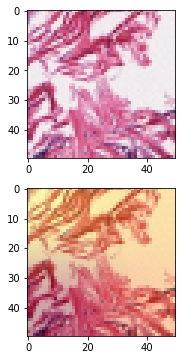

In [4]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (12, 6)

file_path = "data/10272_idx5_x1001_y1001_class0.png"
x_test = load_img(file_path, target_size=(50, 50, 3))
x_test = img_to_array(x_test)  # this is a Numpy array with shape (3, 50, 50)
x_test = preprocess_input(x_test)
f, axes = plt.subplots(2, 1)
pred_class, pred_class_proba, _ = tta_prediction(tta_datagen, model, x_test[np.newaxis, :, :, :], steps=5)
result = pred_dict[pred_class[0]]

# Generate class activation heatmap
last_conv_layer_name = "top_activation"
classifier_layer_names = [layer.name for layer in model.layers][-7:]#["flatten_2", "dense_2"]
heatmap = make_gradcam_heatmap(x_test[np.newaxis]/255., model, last_conv_layer_name, classifier_layer_names)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((x_test.shape[1], x_test.shape[0]))
jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + x_test
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

#clean_old_files(os.path.join(basepath, 'uploads'))
print(f"{pred_dict[pred_class[0]]} with {pred_class_proba*100:.4f}% probability") #preds[0].max()
print(f"{pred_dict[1-pred_class[0]]} with {(1-pred_class_proba)*100:.4f}% probability") #preds[0].max()
axes[0].imshow(x_test.astype("uint8"), interpolation='nearest')
axes[1].imshow(superimposed_img, interpolation='nearest')
time.sleep(0.5)